## Import 

In [5]:
import sys
import numpy as np
import scipy as sp

from models.semisync_5bees import Semisync5bees

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

## Data synthesis visualization

List of data visualization:
1. Multinomial sample of 5 bees model, red dot
2. HPD of Conjugated Multinomial vs Interval of Frequentist

[20, 11, 27, 20, 17, 5]


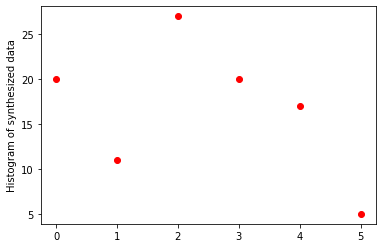

In [19]:
model = Semisync5bees()
N = 100
p_true = [0.3, 0.25, 0.35, 0.45, 0.5]
(s, m, f) = model.sample(params=p_true, sample_size=N)

def plot_multinomial_data(data):
    plt.plot(data, 'ro')
    plt.ylabel('Histogram of synthesized data')
    plt.show()

print(m)
    
plot_multinomial_data(m)

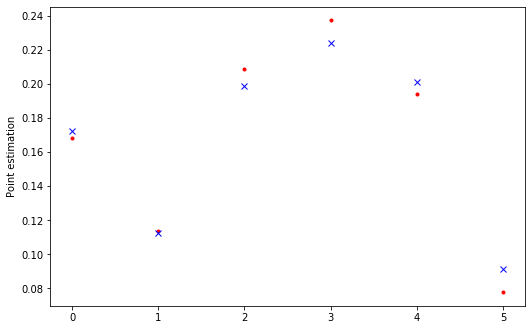

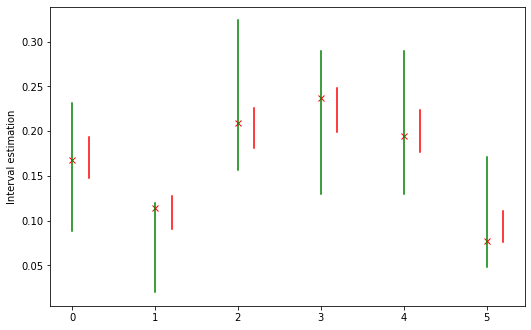

In [32]:
# import pymc3 to use HPD calculation
import pymc3 as pm

# Distance function
def rmse(p, p_hat):
    s = 0
    for it in zip(p, p_hat):
        diff = it[0] - it[1]
        s += diff * diff
    return math.sqrt(s / len(p))

# Frequentist interval
import math
def get_interval(d, N):
    intervals = []
    for di in d:
        z_a2 = 1.96
        margin = z_a2 * math.sqrt(di* (1 - di) / N)
        ub = di + margin
        lb = di - margin
        intervals.append((ub, lb))
    return intervals

# Bayes interval
def bayes_step(data, alpha):
    new_alpha = [sum(x) for x in zip(alpha, data)]
    estimated_p = alpha / sum(alpha)
    return (new_alpha, estimated_p)

def bayes(data):
    K = len(data)
    alpha = np.ones(K)
    estimated_p = np.zeros(K)
    # traces = []
    for i in range(0, len(data)):
        # inference
        alpha, estimated_p = bayes_step(data[i], alpha)
        # traces.append((alpha, estimated_p))
    return (alpha, estimated_p)

def synthesize_data(n_samples, N):
    data = []
    p_tscc_true = model.eval_bscc_pfuncs(p_true)
    for i in range(0, n_samples):
        s = model.sample(params=p_true, sample_size=N)
        data.append(s)
    return data, p_tscc_true

def estimate_params(N):
    n_samples = 10
    data, p_tscc_true = synthesize_data(n_samples, N)
    freq_intervals = []
    for d in data:
        freq_sample = d[2]
        freq_intervals = get_interval(freq_sample, N)
    bayes_intervals = []
    multinomial_samples = [d[1] for d in data]
    alpha_hat, p_hat = bayes(multinomial_samples)
    posterior_sample = np.random.dirichlet(alpha_hat, 1000)
    bayes_intervals = pm.stats.hpd(posterior_sample)
    return (freq_intervals, bayes_intervals, p_hat, p_tscc_true)
    
def visualize_point(p_true, p_hat):
    fig = plt.gcf()
    fig.set_size_inches(8.5, 5.5)
    plt.plot(p_true, 'r.')
    plt.plot(p_hat, 'bx')
    plt.ylabel('Point estimation')
    plt.show()

def visualize_intervals(freq_intervals, bayes_intervals, p_tscc_true):
    fig = plt.gcf()
    fig.set_size_inches(8.5, 5.5)
    plt.plot(p_tscc_true, 'rx')
    for i, it in enumerate(zip(freq_intervals, bayes_intervals)):
        f = it[0]
        b = it[1]
        offset = 0.2
        plt.plot([i, i], [f[0], f[1]], 'g-')
        plt.plot([i + offset, i + offset], [b[0], b[1]], 'r-')
    plt.ylabel('Interval estimation')
    plt.show()
    
(freq_intervals, bayes_intervals, p_hat, p_tscc_true) = estimate_params(N)
visualize_point(p_tscc_true, p_hat)
visualize_intervals(freq_intervals, bayes_intervals, p_tscc_true)
    